In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_excel('./Top_performer_NL.xlsx')
df.columns = df.iloc[0]
df = df[1:]
df.head()

,Name,Market,Subtype,%,Turnover,Turnover in EUR,Volume,Last,CCY
1,BM3EAC,Amsterdam,Common Stock,0,3540,-,-,10,USD
2,IRIS FINANCIAL SHA,Amsterdam,Common Stock,0,-,-,-,10,USD
3,GIG,Amsterdam,Common Stock,-34.33,440,11484.055,1465,4.4,GBP
4,BEVER HOLDING,Amsterdam,Common Stock,-25.88,77531.4,77531.4,29346,2.52,EUR
5,ALMUNDA PRO NV,Amsterdam,Common Stock,-11.97,108458.84,108458.84,85112,1.25,EUR


In [ ]:
def convert_string_to_float(s):
    try:
        # Remove any commas from the string
        s = str(s)  # Convert to string if it's not already
        s = s.replace(",", "")
        # Convert the string to a float
        return float(s)
    except ValueError:
        return None

# Apply the function to the entire column
df['%'] = df['%'].apply(convert_string_to_float)
df['Last'] = df['Last'].apply(convert_string_to_float)
df['Turnover'] = df['Turnover'].apply(convert_string_to_float)
df['Volume'] = df['Volume'].apply(convert_string_to_float)

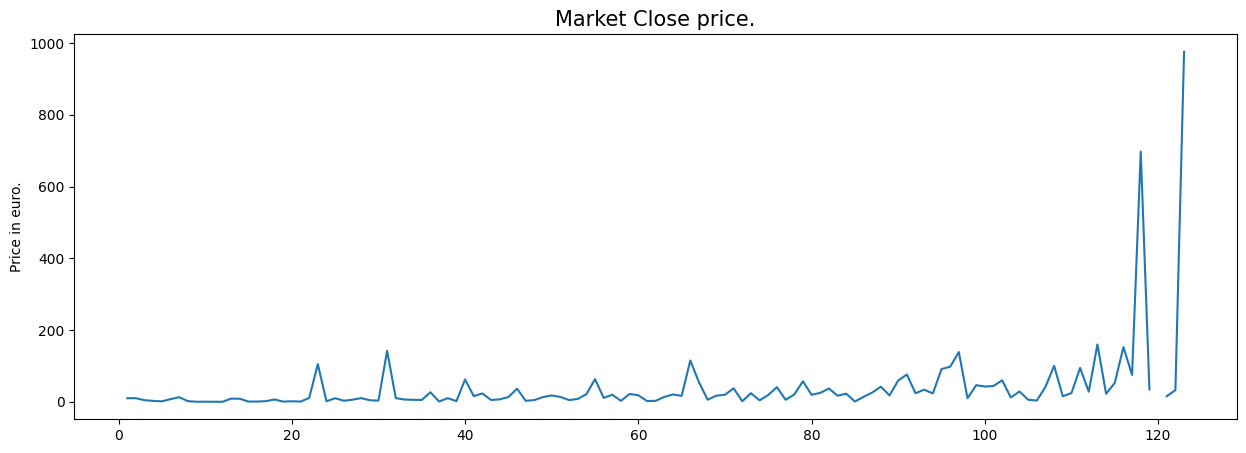

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(df['Last'])
plt.title('Market Close price.', fontsize=15)
plt.ylabel('Price in euro.')
plt.show()

In [ ]:
# check whether data in the ‘Close’ column and that available in the ‘Adj Close’ column is the same with each row or not
#df[df['Close'] == df['Adj Close']].shape
#df = df.drop(['Adj Close'], axis=1)

In [ ]:
# check for null values
df.isnull().sum()

0
Name               0
Market             0
Subtype            0
%                  0
Turnover           0
Turnover in EUR    0
Volume             0
Last               0
CCY                0
dtype: int64

In [ ]:
df.dropna(inplace=True)

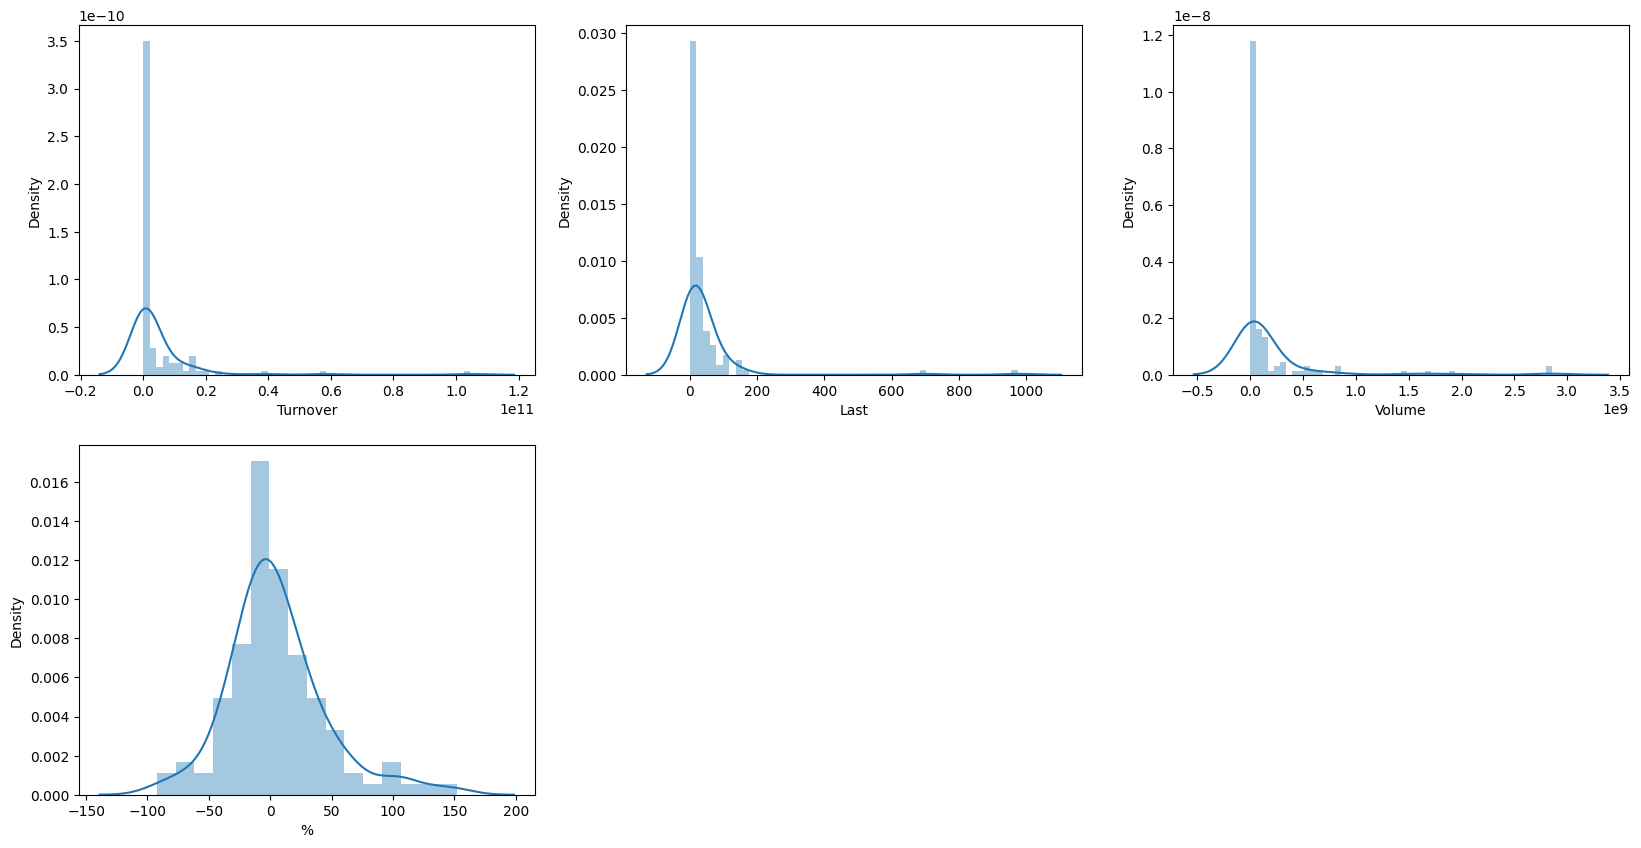

In [ ]:
# visualise features
features = ['Turnover', 'Last', 'Volume', '%']

plt.subplots(figsize=(20,10))

for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.distplot(df[col])
plt.show()

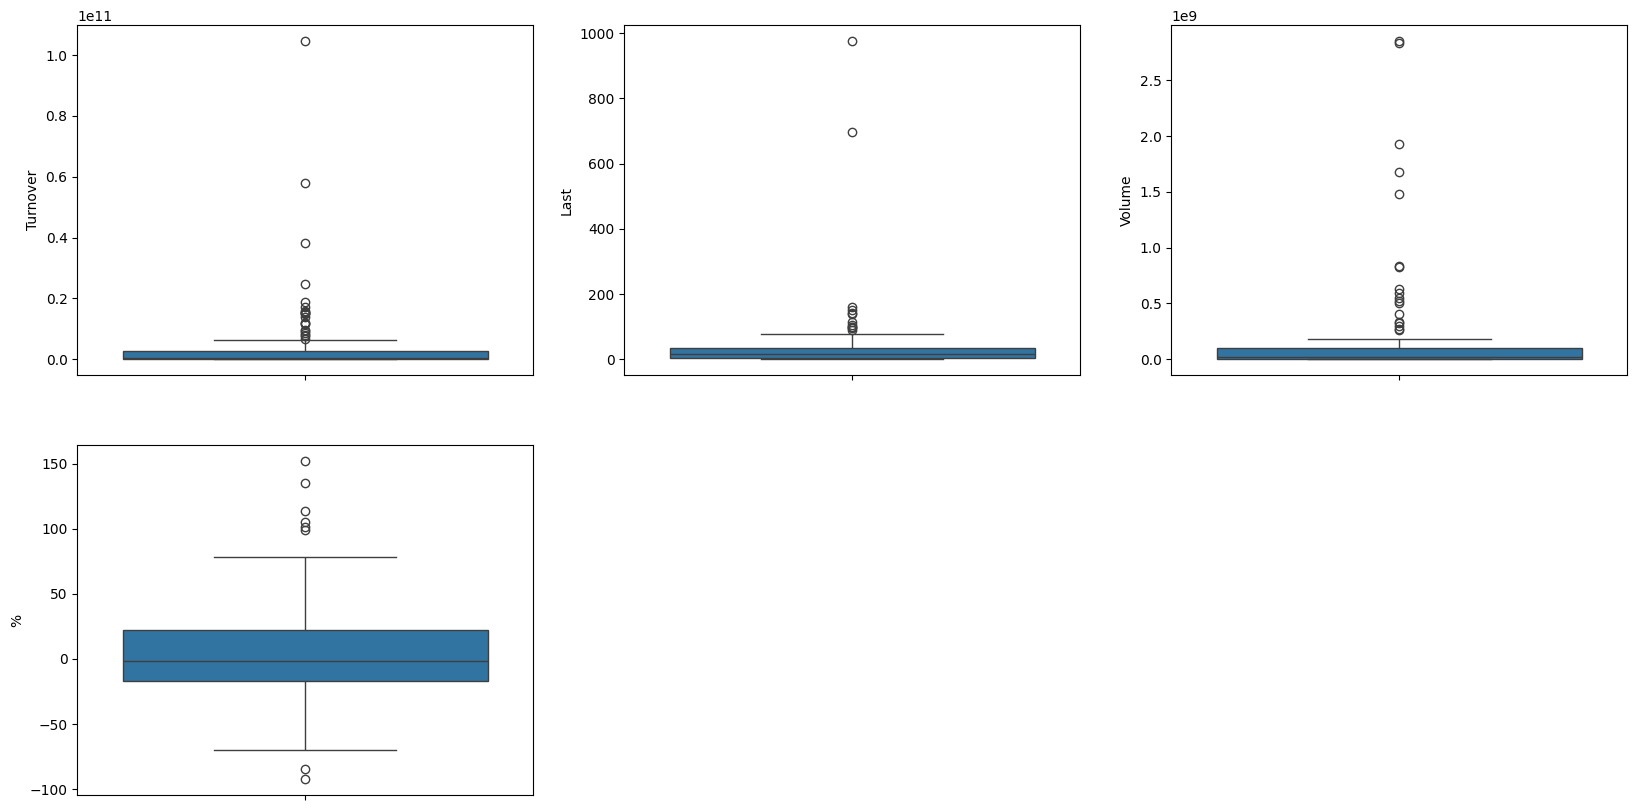

In [ ]:
# from these boxplots we can see if there are any outliers
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.boxplot(df[col])
plt.show()

In [ ]:
# feature Engineering
# quarterly results affect the stock prices heavily
# splitted = df['Date'].str.split('/', expand=True)

# df['day'] = splitted[1].astype('int')
# df['month'] = splitted[0].astype('int')
# df['year'] = splitted[2].astype('int')

# df['is_quarter_end'] = np.where(df['month']%3==0,1,0)

# df['open-close'] = df['Open'] - df['Close']
# df['low-high'] = df['Low'] - df['High']
# target feature is a signal whether to buy or not
df['target'] = np.where(df['Last'].shift(-1) > df['Last'], 1, 0)

df.head()

,Name,Market,Subtype,%,Turnover,Turnover in EUR,Volume,Last,CCY,target
3,GIG,Amsterdam,Common Stock,-34.33,440.00,11484.055,1465.0,4.40,GBP,0
4,BEVER HOLDING,Amsterdam,Common Stock,-25.88,77531.40,77531.4,29346.0,2.52,EUR,0
5,ALMUNDA PRO NV,Amsterdam,Common Stock,-11.97,108458.84,108458.84,85112.0,1.25,EUR,1
6,EUROCASTLE INVEST.,Amsterdam,Common Stock,8.89,203260.65,203260.65,25854.0,7.35,EUR,1
7,PORCELEYNE FLES,Amsterdam,Common Stock,11.30,457277.60,457277.6,36326.0,12.80,EUR,0


In [ ]:
# data_grouped = df.groupby('year').mean()
# plt.subplots(figsize=(20,10))

# for i, col in enumerate(['Last', 'Volume', '%', 'Turnover']):
#   plt.subplot(2,2,i+1)
#   data_grouped[col].plot.bar()
# plt.show()

In [ ]:
# Check whether Prices are higher in the months which are quarter end as compared to that of the non-quarter end months.
# Check the volume of trades in the months which are quarter end.
#df.groupby('is_quarter_end').mean()

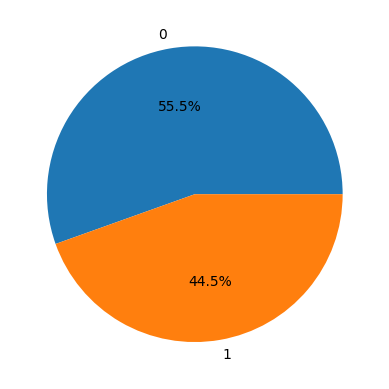

In [ ]:
plt.pie(df['target'].value_counts().values,
		labels=[0, 1], autopct='%1.1f%%')
plt.show()

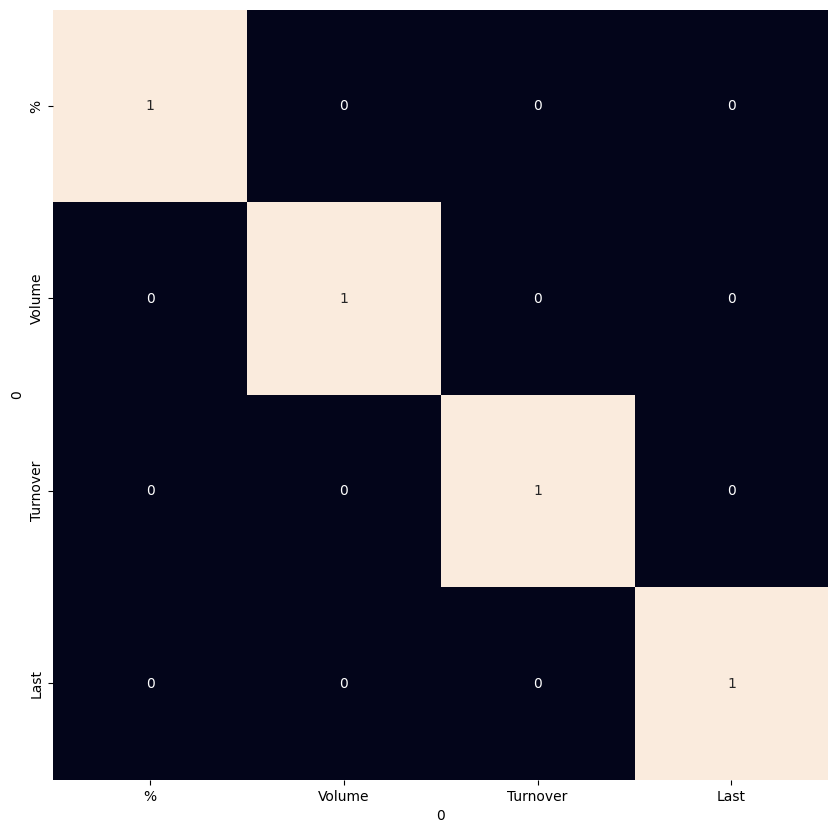

In [ ]:
df_feat = df[['%', 'Volume','Turnover','Last']]
plt.figure(figsize=(10, 10))

# As our concern is with the highly correlated features only so, we will visualize our heatmap as per that criteria only.
sb.heatmap(df_feat.corr() > 0.9, annot=True, cbar=False)
plt.show()

# New Section

In [ ]:
# Data splitting and Normalization
features = df[['Volume', 'Turnover', '%']]
target = df['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)

X_train, X_valid, Y_train, Y_valid = train_test_split(
	features, target, test_size=0.1, random_state=2022)
print(X_train.shape, X_valid.shape)

(107, 3) (12, 3)


In [ ]:
# Model development and Evaluation
#  instead of predicting the hard probability that is 0 or 1 we would like it to predict soft probabilities that are continuous values between 0 to 1.
# And with soft probabilities, the ROC-AUC curve is generally used
models = [LogisticRegression(), SVC(
kernel='poly', probability=True), XGBClassifier()]

for i in range(3):
  models[i].fit(X_train, Y_train)

print(f'{models[i]} : ')
print('Training Accuracy : ', metrics.roc_auc_score(
	Y_train, models[i].predict_proba(X_train)[:,1]))
print('Validation Accuracy : ', metrics.roc_auc_score(
	Y_valid, models[i].predict_proba(X_valid)[:,1]))
print()

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  1.0
Validation Accuracy :  0.765625



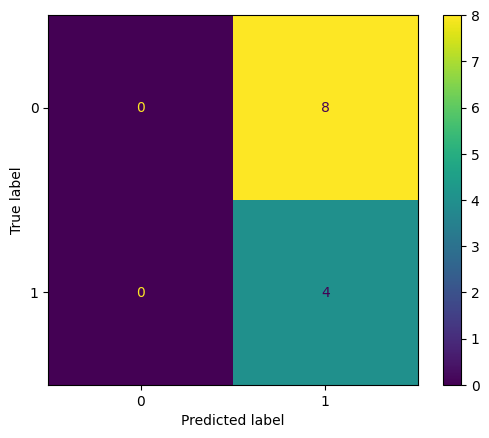

In [ ]:
ConfusionMatrixDisplay.from_estimator(models[0], X_valid, Y_valid)
plt.show()
